In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import nemo, nemo_asr
import numpy as np

import scipy.io.wavfile as wave

In [2]:
MODEL_YAML = './examples/asr/configs/jasper10x5dr.yaml'
CHECKPOINT_ENCODER = '/raid/data/Jasper10x5DR/JasperEncoder_3-STEP-218410.pt'
CHECKPOINT_DECODER = '/raid/data/Jasper10x5DR/JasperDecoderForCTC_4-STEP-218410.pt'

In [3]:
from ruamel.yaml import YAML
yaml = YAML(typ="safe")
with open(MODEL_YAML) as f:
    jasper_model_definition = yaml.load(f)
labels = jasper_model_definition['labels']

In [4]:
neural_factory = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
    backend=nemo.core.Backend.PyTorch)

In [5]:
data_preprocessor = nemo_asr.AudioPreprocessing(
    factory=neural_factory,
    **jasper_model_definition["AudioPreprocessing"])

jasper_encoder = nemo_asr.JasperEncoder(
    feat_in=jasper_model_definition["AudioPreprocessing"]["features"],
    **jasper_model_definition["JasperEncoder"])

jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=jasper_model_definition["JasperEncoder"]["jasper"][-1]["filters"],
    num_classes=len(labels))

greedy_decoder = nemo_asr.GreedyCTCDecoder()

2019-10-11 19:43:14,531 - INFO - PADDING: 16
2019-10-11 19:43:14,532 - INFO - STFT using conv


In [6]:
jasper_encoder.restore_from(CHECKPOINT_ENCODER)
jasper_decoder.restore_from(CHECKPOINT_DECODER)

In [7]:
sample_rate, signal = wave.read('/raid/data/librispeech/LibriSpeech/dev-clean-wav/1272-128104-0000.wav')

# make sure that sample rate is the same as expected by Jasper
assert sample_rate == jasper_model_definition['sample_rate']

In [8]:
from nemo.backends.pytorch.nm import DataLayerNM
from nemo.core.neural_types import NeuralType, BatchTag, TimeTag, AxisType
import torch

class AudioDataLayer(DataLayerNM):
    @staticmethod
    def create_ports():
        input_ports = {}
        output_ports = {
            "audio_signal": NeuralType({0: AxisType(BatchTag),
                                        1: AxisType(TimeTag)}),

            "a_sig_length": NeuralType({0: AxisType(BatchTag)}),
        }
        return input_ports, output_ports

    def __init__(self, **kwargs):
        DataLayerNM.__init__(self, **kwargs)
        self.output_enable = False
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output_enable:
            raise StopIteration
        self.output_enable = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = np.reshape(signal.astype(np.float32)/32768., [1, -1])
        self.signal_shape = np.expand_dims(self.signal.size, 0).astype(np.int64)
        self.output_enable = True

    def __len__(self):
        return 1

    @property
    def dataset(self):
        return None

    @property
    def data_iterator(self):
        return self

In [9]:
# Instantiate necessary neural modules
data_layer = AudioDataLayer()

# Define inference DAG
audio_signal, audio_signal_len = data_layer()
processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)
encoded, encoded_len = jasper_encoder(audio_signal=processed_signal,
                                      length=processed_signal_len)
log_probs = jasper_decoder(encoder_output=encoded)
predictions = greedy_decoder(log_probs=log_probs)

In [10]:
data_layer.set_signal(signal)
tensors = neural_factory.infer([
    audio_signal,
    processed_signal,
    encoded,
    log_probs,
    predictions,
])
audio = tensors[0][0][0].cpu().numpy()
features = tensors[1][0][0].cpu().numpy()
encoded_features = tensors[2][0][0].cpu().numpy(),
probs = tensors[3][0][0].cpu().numpy()
preds = tensors[4][0]

Evaluating batch 0 out of 1


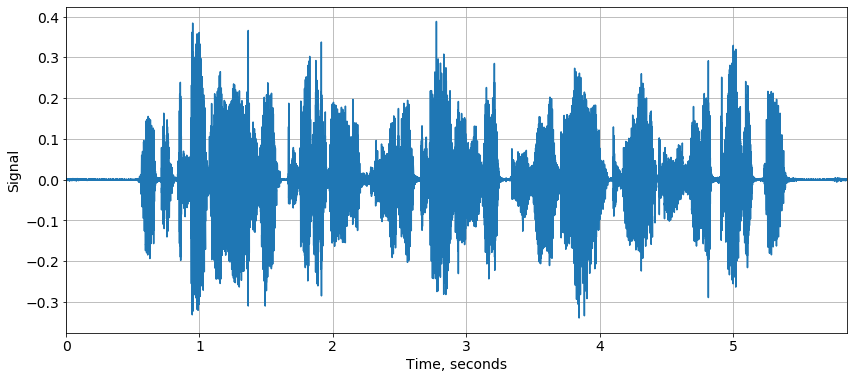

In [11]:
plt.figure(figsize=[14,6])
plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})
plt.plot(np.arange(audio.size)/sample_rate, audio)
plt.xlim([0, audio.size/sample_rate])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

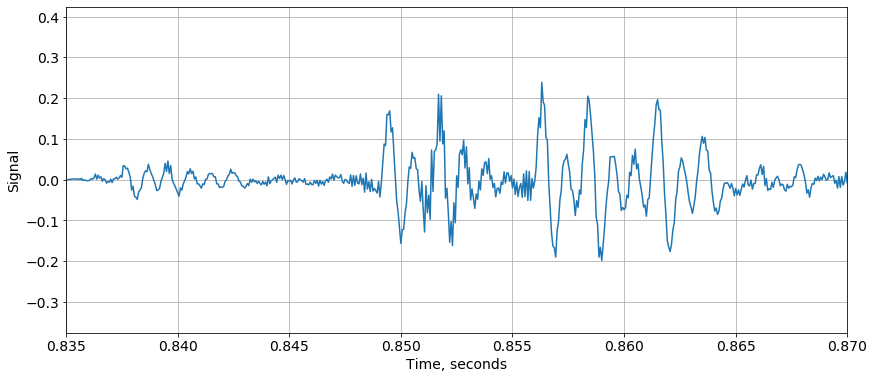

In [12]:
plt.figure(figsize=[14,6])
plt.plot(np.arange(audio.size)/sample_rate, audio)
plt.xlim([0.835, 0.87])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

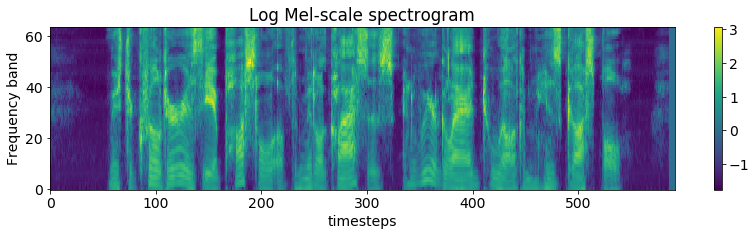

In [13]:
plt.figure(figsize=[14,3])
plt.imshow(features)
plt.axis('tight')
plt.ylabel('Frequency band')
plt.xlabel('timesteps')
plt.colorbar()
plt.title('Log Mel-scale spectrogram')
plt.gca().invert_yaxis()

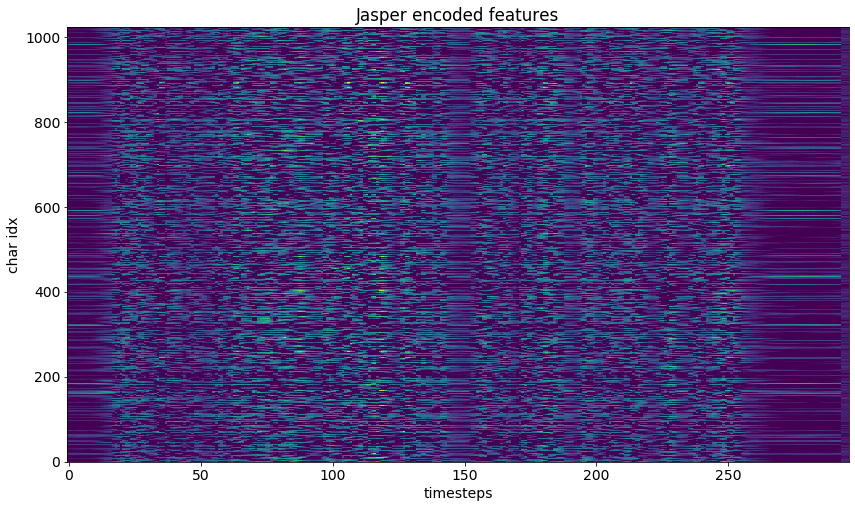

In [14]:
plt.figure(figsize=[14,8])
plt.imshow(encoded_features[0])
plt.axis('tight')
plt.ylabel('char idx')
plt.xlabel('timesteps')
plt.title('Jasper encoded features')
plt.gca().invert_yaxis()

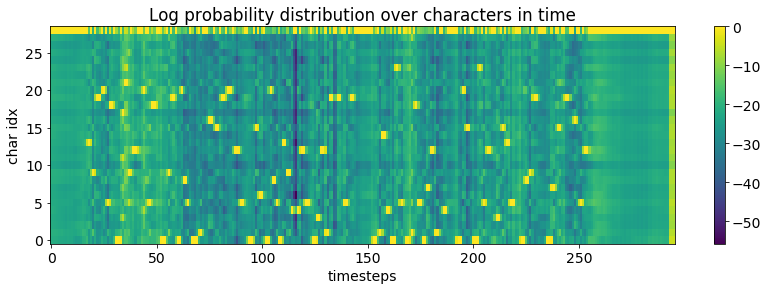

In [15]:
plt.figure(figsize=[14,4])
plt.imshow(probs.transpose())
plt.axis('tight')
plt.ylabel('char idx')
plt.xlabel('timesteps')
plt.colorbar()
plt.title('Log probability distribution over characters in time')
plt.gca().invert_yaxis()

In [16]:
from nemo_asr.helpers import post_process_predictions
post_process_predictions([preds], labels)

['mister quilter is the apostle of the middle classes and we are glad to welcome his gospel']